# Understanding spot coverage vs amplitude

Let's simulate a star and pre-compute its amplitude function. This uses the `feat-jax` branch

In [75]:
import numpy as np
from spotter import Star, uniform
import matplotlib.pyplot as plt

star = Star(u=[0.1, 0.2], N=2**5)
amplitude = star.jax_amplitude(resolution=20)

We now add spots to a clean surface, each time recording the spot coverage and the resulting variability amplitude. We do that for different spot radii, assuming that a surface is covered by spots of similar sizes (although in reality they might have different sizes) uniformly distributed

In [52]:
from tqdm import tqdm
from collections import defaultdict

results = []
radii = np.linspace(0.01, np.pi / 2, 20)
contrast = 0.1
covering_fraction = []

n_spots = 200
n_stars = 100
max_cov = 0.9

amplitude = star.jax_amplitude(resolution=20)

covs = defaultdict(list)
amplitudes = defaultdict(list)

for i, r in enumerate(tqdm(radii)):
    inter_results = []
    inter_covering_fraction = []
    for _ in range(n_stars):
        star.clear_surface()
        n = 0
        # this is to ensure that we add at least
        # n_spots despite the max_cov constraint
        while n < n_spots:
            star.clear_surface()
            for _ in range(n_spots):
                theta, phi = uniform(1)
                star.add_spot(theta, phi, r, contrast)
                n += 1
                amp = amplitude(star.map_spot)
                amplitudes[i].append(amp)
                cov = star.covering_fraction()
                covs[i].append(cov)
                if cov > max_cov:
                    break

100%|██████████| 30/30 [04:34<00:00,  9.15s/it]


Let's plot the results. We use some binning to see mean trends out of all draws


In [54]:
def index_binning(x, size):
    if isinstance(size, float):
        bins = np.arange(np.min(x), np.max(x), size)
    else:
        x = np.arange(0, len(x))
        bins = np.arange(0.0, len(x), size)

    d = np.digitize(x, bins)
    n = np.max(d) + 2
    indexes = []

    for i in range(0, n):
        s = np.where(d == i)
        if len(s[0]) > 0:
            s = s[0]
            indexes.append(s)

    return indexes

<>:27: SyntaxWarning: invalid escape sequence '\p'
<>:27: SyntaxWarning: invalid escape sequence '\p'
/var/folders/wn/j_ytm31108z7jt5f1x0d7j1c0000gq/T/ipykernel_3737/3758234691.py:27: SyntaxWarning: invalid escape sequence '\p'
  plt.colorbar(s_m, label="Spot radius ($\pi /2$)", ax=plt.gca())


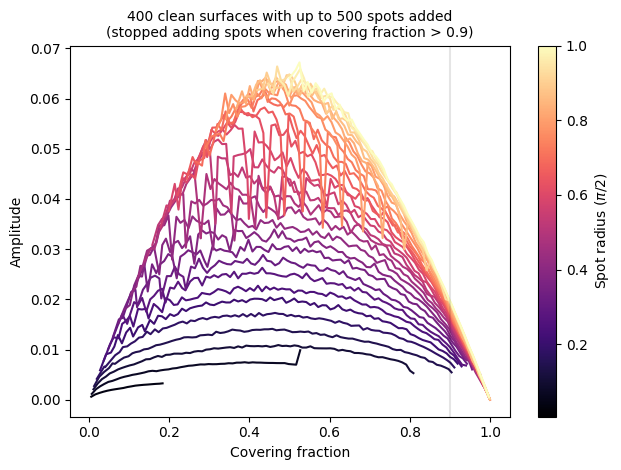

In [55]:
import matplotlib

angle = radii / (np.pi / 2)

# 20 colors from the viridis colro palette
s_m = matplotlib.cm.ScalarMappable(
    cmap="magma", norm=plt.Normalize(vmin=np.min(angle), vmax=np.max(angle))
)

for i in np.arange(0, len(covs), 1):
    c, a = np.array(covs[i]), np.array(amplitudes[i])
    if len(c) == 0:
        continue
    idxs = index_binning(c, 0.01)
    color = s_m.to_rgba(angle[i])
    _std_a = np.array([a[idx].std() for idx in idxs])
    _a = np.array([a[idx].mean() for idx in idxs])
    _c = np.array([c[idx].mean() for idx in idxs])
    plt.plot(_c, _a, "-", color=color)
    # plt.fill_between(_c, _a - _std_a, _a + _std_a, alpha=0.5, color=color)
    plt.xlabel("Covering fraction")
    plt.ylabel("Amplitude")

plt.axvline(0.9, alpha=0.1, c="k")


plt.colorbar(s_m, label="Spot radius ($\pi /2$)", ax=plt.gca())
plt.title(
    "400 clean surfaces with up to 500 spots added\n(stopped adding spots when covering fraction > 0.9)",
    fontsize=10,
)

plt.tight_layout()

Here is a plot showing the variance around the mean amplitude

<>:20: SyntaxWarning: invalid escape sequence '\p'
<>:20: SyntaxWarning: invalid escape sequence '\p'
/var/folders/wn/j_ytm31108z7jt5f1x0d7j1c0000gq/T/ipykernel_3737/448441768.py:20: SyntaxWarning: invalid escape sequence '\p'
  plt.colorbar(s_m, label="Spot radius ($\pi /2$)", ax=plt.gca())


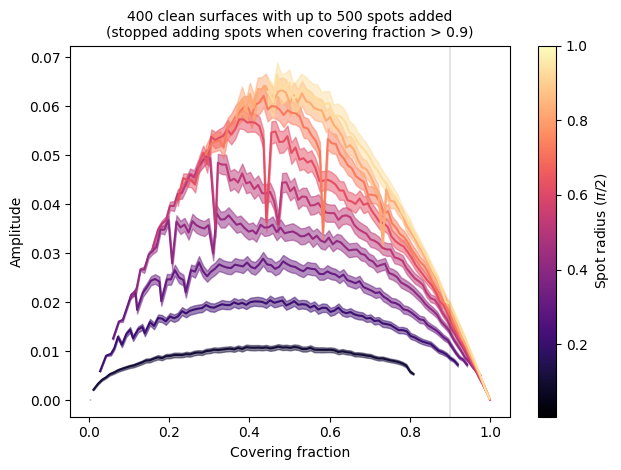

In [58]:
for i in np.arange(0, len(covs), 3):
    c, a = np.array(covs[i]), np.array(amplitudes[i])
    if len(c) == 0:
        continue
    idxs = index_binning(c, 0.01)
    color = s_m.to_rgba(angle[i])
    _std_a = np.array([a[idx].std() / np.sqrt(len(idxs)) for idx in idxs])
    _a = np.array([a[idx].mean() for idx in idxs])
    _c = np.array([c[idx].mean() for idx in idxs])
    plt.plot(_c, _a, "-", color=color)
    plt.fill_between(_c, _a - _std_a, _a + _std_a, alpha=0.5, color=color)
    plt.xlabel("Covering fraction")
    plt.ylabel("Amplitude")

plt.axvline(0.9, alpha=0.1, c="k")
plt.title(
    "400 clean surfaces with up to 500 spots added\n(stopped adding spots when covering fraction > 0.9)",
    fontsize=10,
)
plt.colorbar(s_m, label="Spot radius ($\pi /2$)", ax=plt.gca())
plt.tight_layout()
plt.savefig("spot_cov_with_var_2.png", dpi=200)

The peculiar dips can be simply explained by few spots being presents. If they don't overlap, n spots will produce a predictable surface coverage (see vertical lines in next plot). However their respective positions will lead to different variability amplitudes, which explain the variance around each dip (see next plot)

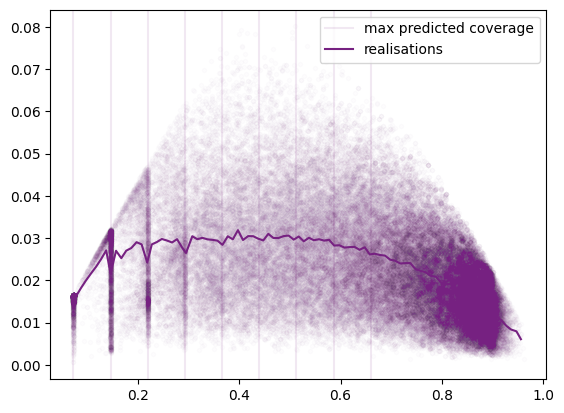

In [87]:
def spot_coverage(radius):
    """coverage of a single spot on a sphere"""
    return (1 - np.cos(radius)) / 2


def plot(i):
    color = s_m.to_rgba(angle[i])
    c, a = np.array(covs[i]), np.array(amplitudes[i])
    plt.plot(c, a, ".", color=color, alpha=0.01)
    idxs = index_binning(c, 0.01)
    _a = np.array([a[idx].mean() for idx in idxs])
    _c = np.array([c[idx].mean() for idx in idxs])
    plt.plot(_c, _a, "-", color=color, label="realisations")


spot_i = 10
for i in range(1, 10):
    x = i * spot_coverage(radii[spot_i])
    if x < 1:
        plt.axvline(
            x,
            c=s_m.to_rgba(angle[spot_i]),
            alpha=0.1,
            label="max predicted coverage" if i == 1 else None,
        )
    else:
        break

plot(spot_i)
plt.legend()

Of course the more spots are added the less likely it is that they are placed symmetrically on the sphere (which I think is the case producing the lowest amplitude variability). Hence dips are less frequent with higher number of spots.

The bulk to the right is showing how adding more spot slowly makes the coverage go to 1 without contributing much to the amplitude